In [1]:
import scanpy as sc
from scipy.io import mmwrite, mmread
import pandas as pd
import numpy as np

In [2]:
atac_adata = sc.read_h5ad('scButterfly/data/lymphoma/lymphoma_ATAC.h5ad')
rna_adata = sc.read_h5ad('scButterfly/data/lymphoma/lymphoma_RNA.h5ad')

/opt/conda/lib/python3.11/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [ ]:
# Create .mtx files for RNA and ATAC data
mmwrite('Polarbear/data/lymphoma_ATAC.mtx', atac_adata.X)
mmwrite('Polarbear/data/lymphoma_RNA.mtx', rna_adata.X)

In [ ]:
# Create chromosome list .csv file from ATAC
np.savetxt('Polarbear/data/Lymphoma_ATAC_chr.csv', np.array(rna_adata.var_names), delimiter=',', fmt='%s')

In [ ]:
# Remove x and y chromosome from csv file and sorted list of peaks per chr
chr_annot = pd.read_csv('Polarbear/data/Lymphoma_ATAC_chr.csv', sep=':', header=None)
chr_annot.columns = ['chr','pos']
chr_list = {}
for chri in chr_annot['chr'].unique():
    if chri not in ['chrX','chrY']:
        chr_list[int(chri[3:])] = [i for i, x in enumerate(chr_annot['chr']) if x == chri];

chr_list_range = []
for chri in chr_list.keys():
    chr_list_range += chr_list[chri]

In [ ]:
# Create barcode .csv file
pd.DataFrame(list(rna_adata.obs_names), columns=['index']).to_csv('Polarbear/data/lym_RNA_barcodes.csv', index=False)

In [ ]:
pred_RNA = sc.read_text('Polarbear/data/output_first_run/outputfirst_train_test_rnanorm_pred.txt')
test_barcodes = pd.read_csv('Polarbear/data/output_first_run/outputfirst_train_test_barcodes.txt', sep='\t', header=None)

In [ ]:
pred_RNA.obs_names = test_barcodes[0].values
pred_RNA.obs = pd.concat([pred_RNA.obs, rna_adata.obs.loc[pred_RNA.obs_names,'Cell Types']], axis=1)

In [31]:
pred_RNA.var_names = rna_adata.var_names
pred_RNA.var = pd.concat([pred_RNA.var, rna_adata.var[['gene_ids', 'feature_types', 'genome', 'interval']]], axis=1)

In [34]:
sc.pp.normalize_total(pred_RNA, target_sum=1e6)
sc.pp.log1p(pred_RNA)
sc.pp.highly_variable_genes(pred_RNA, n_top_genes=3000)
sc.pp.pca(pred_RNA, n_comps=50)
sc.pp.neighbors(pred_RNA, n_neighbors=15, use_rep='X_pca')
sc.tl.umap(pred_RNA, random_state=22)


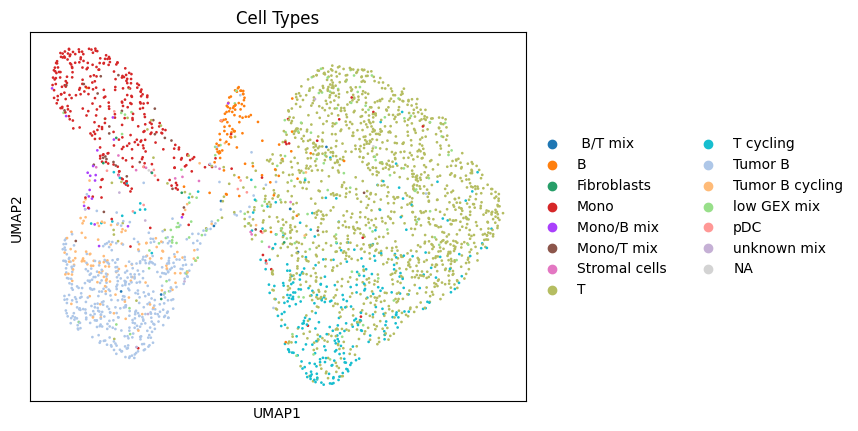

In [38]:
sc.pl.umap(pred_RNA, color="Cell Types", size=15)